# Reinforcement Learning

In [ ]:
#pip install plotly

In [ ]:
#pip install --upgrade nbformat

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [3]:
prices = np.loadtxt(
    '../data/prices_btc_Jan_11_2020_to_May_22_2020.txt',
    dtype=float
    )

In [4]:
prices[:10]

array([7970.96, 7969.76, 7968.18, 7968.2 , 7970.66, 7969.31, 7970.33,
       7971.12, 7969.42, 7968.51])

In [5]:
len(prices)

1141281

In [6]:
df = pd.DataFrame({"prices": prices})

df.sample(10)

,prices
1092047,9525.00
7089,7824.34
471334,8722.86
609702,6321.00
978099,8830.50
649266,6608.28
740387,6803.05
896042,7559.56
300147,10352.49
910432,7583.90


<Axes: >

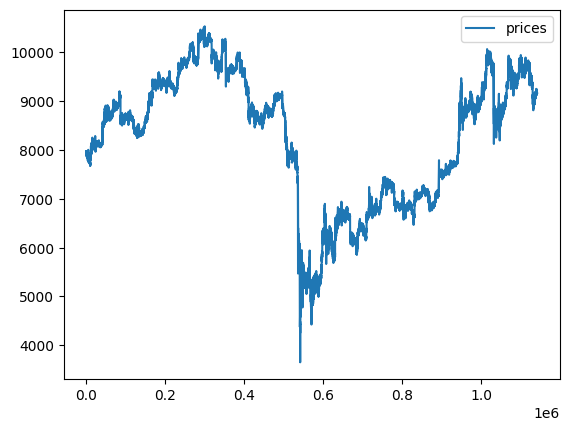

In [7]:
sns.lineplot(
    df,
)

In [9]:
def buy(btc_price, btc, money):
    if(money != 0):
        btc = (1 / btc_price ) * money
        money = 0
    return btc, money


def sell(btc_price, btc, money):
    if(btc != 0):
        money = btc_price * btc
        btc = 0
    return btc, money


def wait(btc_price, btc, money):
    # do nothing
    return btc, money

In [10]:
np.random.seed(1)

# set of actions that the user could do
actions = {
    'buy': buy,
    'sell': sell,
    'wait': wait
}

actions_to_nr = { 'buy' : 0, 'sell' : 1, 'wait' : 2 }
nr_to_actions = { k:v for (k,v) in enumerate(actions_to_nr) }

nr_actions = len(actions_to_nr.keys())
nr_states = len(prices)

# q-table = reference table for our agent to select the best action based on the q-value
q_table = np.random.rand(nr_states, nr_actions)

In [11]:
actions_to_nr

{'buy': 0, 'sell': 1, 'wait': 2}

In [13]:
def get_reward(before_btc, btc, before_money, money):
    reward = 0
    if(btc != 0):
        if(before_btc < btc):
            reward = 1
    if(money != 0):
        if(before_money < money):
            reward = 1
            
    return reward

In [14]:
def choose_action(state):
    if np.random.uniform(0, 1) < eps:
        return np.random.randint(0, 2)
    else:
        return np.argmax(q_table[state])

In [15]:
def take_action(state, action):
    return actions[nr_to_actions[action]](prices[state], btc, money)

In [16]:
def act(state, action, theta):
    btc, money = theta
    
    done = False
    new_state = state + 1
    
    before_btc, before_money = btc, money
    btc, money = take_action(state, action)
    theta = btc, money
    
    reward = get_reward(before_btc, btc, before_money, money)
    
    if(new_state == nr_states):
        done = True
    
    return new_state, reward, theta, done

In [17]:
reward = 0
btc = 0
money = 100

theta = btc, money

In [18]:
# exploratory
eps = 0.3

n_episodes = 20
min_alpha = 0.02

# learning rate for Q learning
alphas = np.linspace(1.0, min_alpha, n_episodes)

# discount factor, used to balance immediate and future reward
gamma = 1.0

In [19]:
rewards = {}

for e in range(n_episodes):
    
    total_reward = 0
    
    state = 0
    done = False
    alpha = alphas[e]
    
    while(done != True):

        action = choose_action(state)
        next_state, reward, theta, done = act(state, action, theta)
        
        total_reward += reward
        
        if(done):
            rewards[e] = total_reward
            print(f"Episode {e + 1}: total reward -> {total_reward}")
            break
        
        q_table[state][action] = q_table[state][action] + alpha * (reward + gamma *  np.max(q_table[next_state]) - q_table[state][action])

        state = next_state

Episode 1: total reward -> 620440
Episode 2: total reward -> 699087
Episode 3: total reward -> 724375
Episode 4: total reward -> 747267
Episode 5: total reward -> 764115
Episode 6: total reward -> 776896
Episode 7: total reward -> 788167
Episode 8: total reward -> 795288
Episode 9: total reward -> 799318
Episode 10: total reward -> 801008
Episode 11: total reward -> 805395
Episode 12: total reward -> 808962
Episode 13: total reward -> 810367
Episode 14: total reward -> 811362
Episode 15: total reward -> 813103
Episode 16: total reward -> 813193
Episode 17: total reward -> 813072
Episode 18: total reward -> 813205
Episode 19: total reward -> 813811
Episode 20: total reward -> 814285


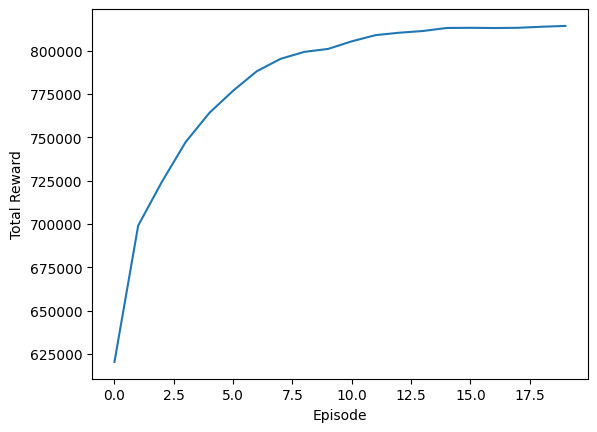

In [20]:
plt.ylabel('Total Reward')
plt.xlabel('Episode')
plt.plot([rewards[e] for e in rewards.keys()])

In [21]:
state = 0
acts = np.zeros(nr_states)
done = False

while(done != True):

        action = choose_action(state)
        next_state, reward, theta, done = act(state, action, theta)
        
        acts[state] = action
        
        total_reward += reward
        
        if(done):
            break
            
        state = next_state

In [22]:
buys_idx = np.where(acts == 0)
wait_idx = np.where(acts == 2)
sell_idx = np.where(acts == 1)

In [ ]:
wait_idx

In [ ]:
buys_idx

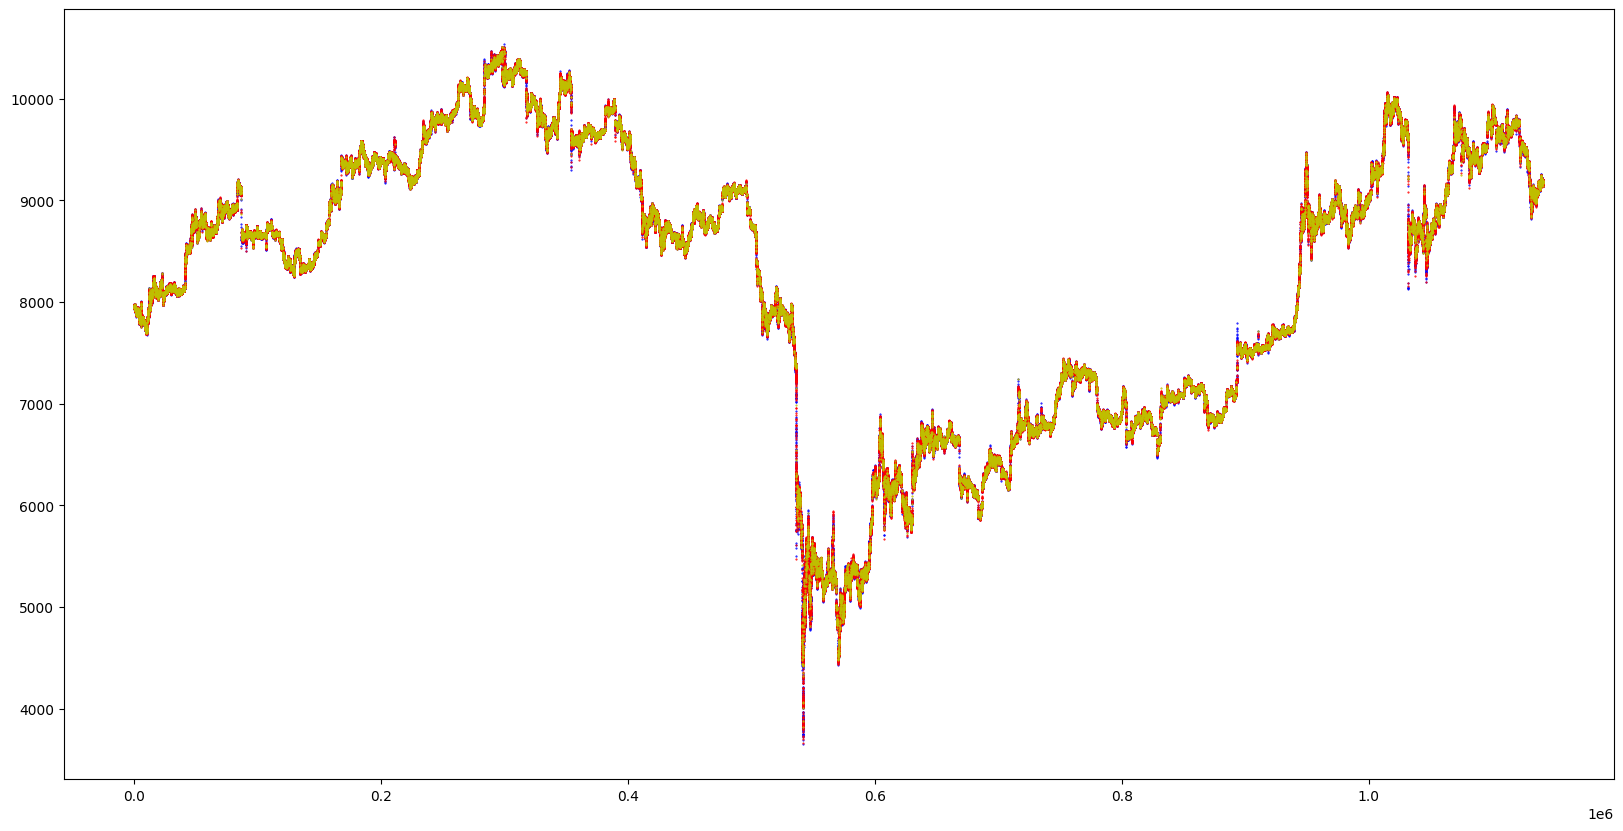

In [23]:
plt.figure(figsize=(20,10))
plt.plot(buys_idx[0], prices[buys_idx], 'bo', markersize=0.5)
plt.plot(sell_idx[0], prices[sell_idx], 'ro', markersize=0.5)
plt.plot(wait_idx[0], prices[wait_idx], 'yo', markersize=0.5)

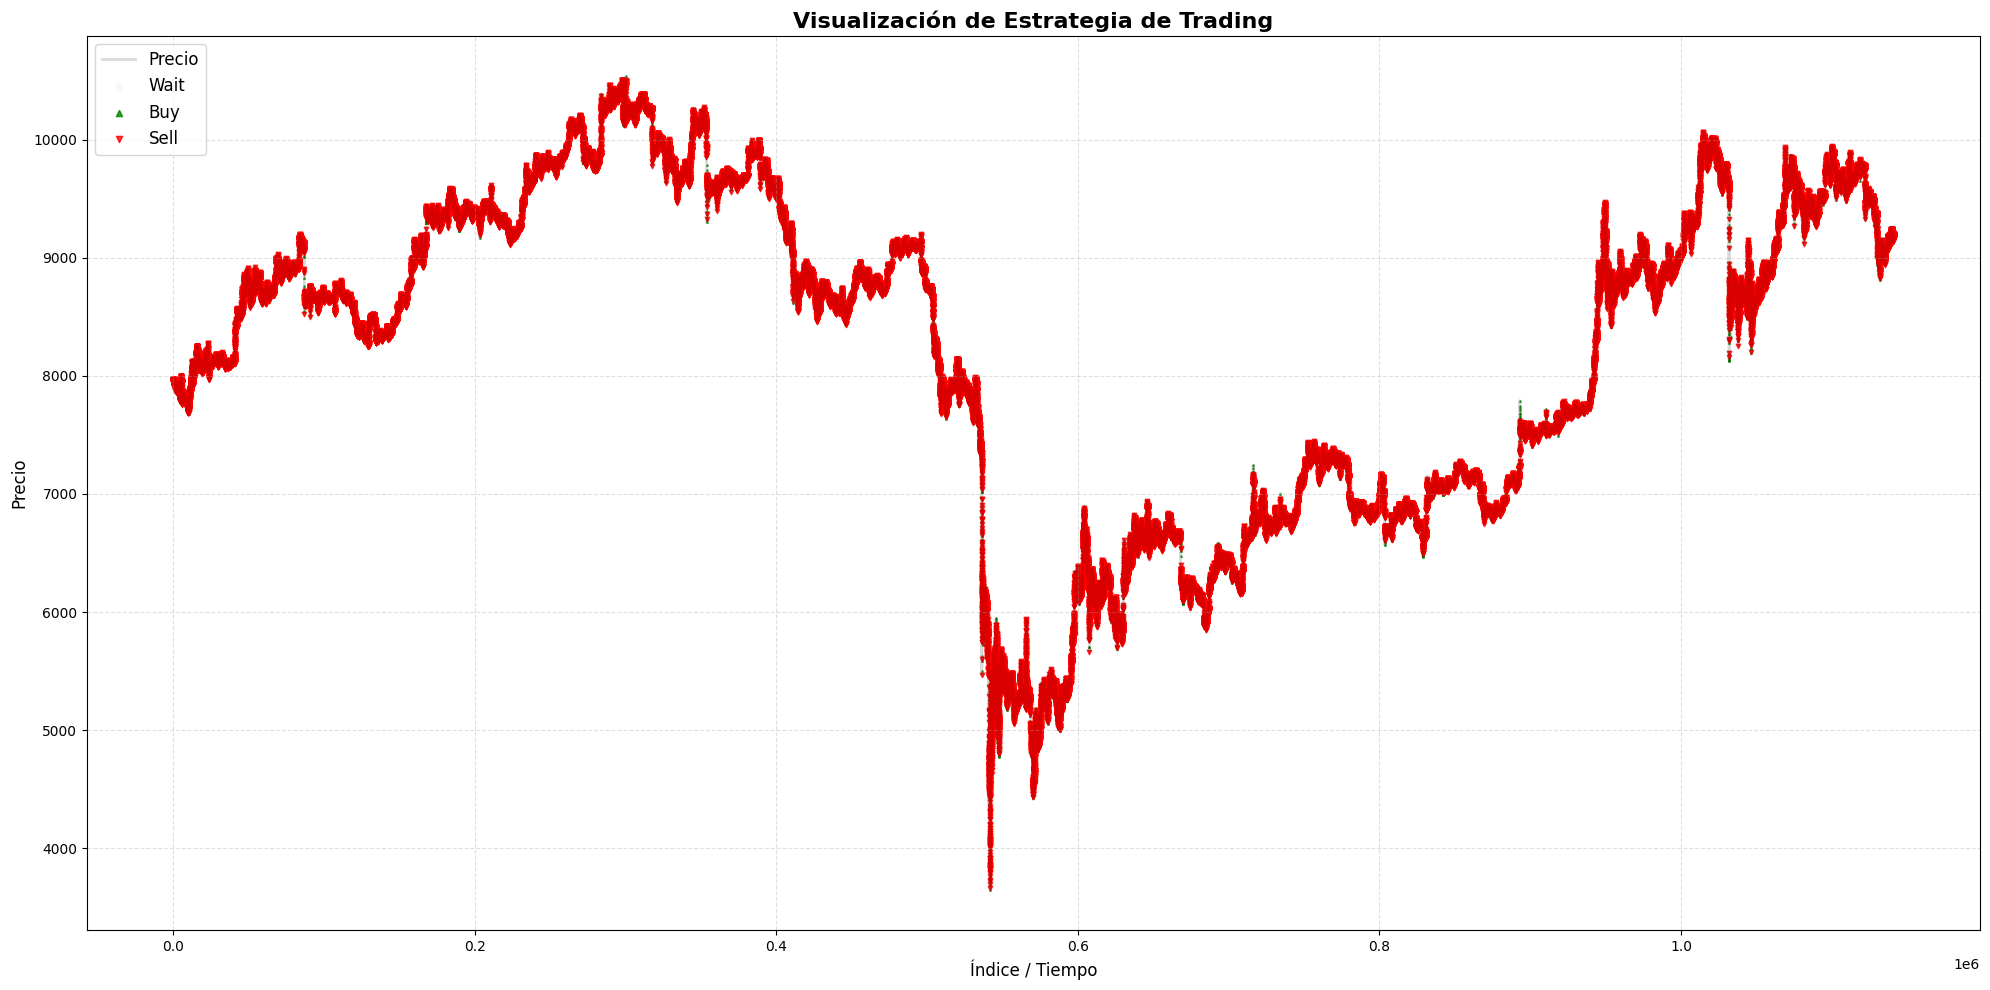

In [24]:
b_idx = buys_idx[0] if isinstance(buys_idx, tuple) else buys_idx
s_idx = sell_idx[0] if isinstance(sell_idx, tuple) else sell_idx
w_idx = wait_idx[0] if isinstance(wait_idx, tuple) else wait_idx

# --- Configuración del Gráfico ---
plt.style.use('seaborn-v0_8-muted') 
plt.figure(figsize=(20, 10))

# 1. Trazar la línea de precio (fondo)
plt.plot(prices, color='black', alpha=0.15, linewidth=2, label='Precio')

# 2. Trazar puntos de 'Wait' (Esperar) - Muy pequeños y tenues
plt.scatter(w_idx, prices[w_idx], color='gray', s=1, alpha=0.05, label='Wait')

# 3. Trazar señales de Compra (Triángulos verdes hacia arriba)
plt.scatter(b_idx, prices[b_idx], color='green', marker='^', s=1, alpha=0.8, label='Buy')

# 4. Trazar señales de Venta (Triángulos rojos hacia abajo)
plt.scatter(s_idx, prices[s_idx], color='red', marker='v', s=10, alpha=0.8, label='Sell')

# --- Personalización y Estética ---
plt.title('Visualización de Estrategia de Trading', fontsize=16, fontweight='bold')
plt.xlabel('Índice / Tiempo', fontsize=12)
plt.ylabel('Precio', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)

# --- Corrección de la Leyenda (El error anterior) ---
lgnd = plt.legend(loc="upper left", scatterpoints=1, fontsize=12, frameon=True)

for handle in lgnd.legend_handles:
    # Si es un objeto de Scatter (PathCollection)
    if hasattr(handle, 'set_sizes'):
        handle.set_sizes([20.0])
    # Si es un objeto de Línea (Line2D)
    elif hasattr(handle, 'set_markersize'):
        handle.set_markersize(10.0)

plt.tight_layout()
plt.show()